In [6]:
!pip install fredapi
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install python-dotenv
!pip install seaborn
!pip install yfinance


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
  Using cached python_dotenv-1.0.1-py3-none-any.whl.metadata (23 kB)
Using cached python_dotenv-1.0.1-py3-none-any.whl (19 kB)

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


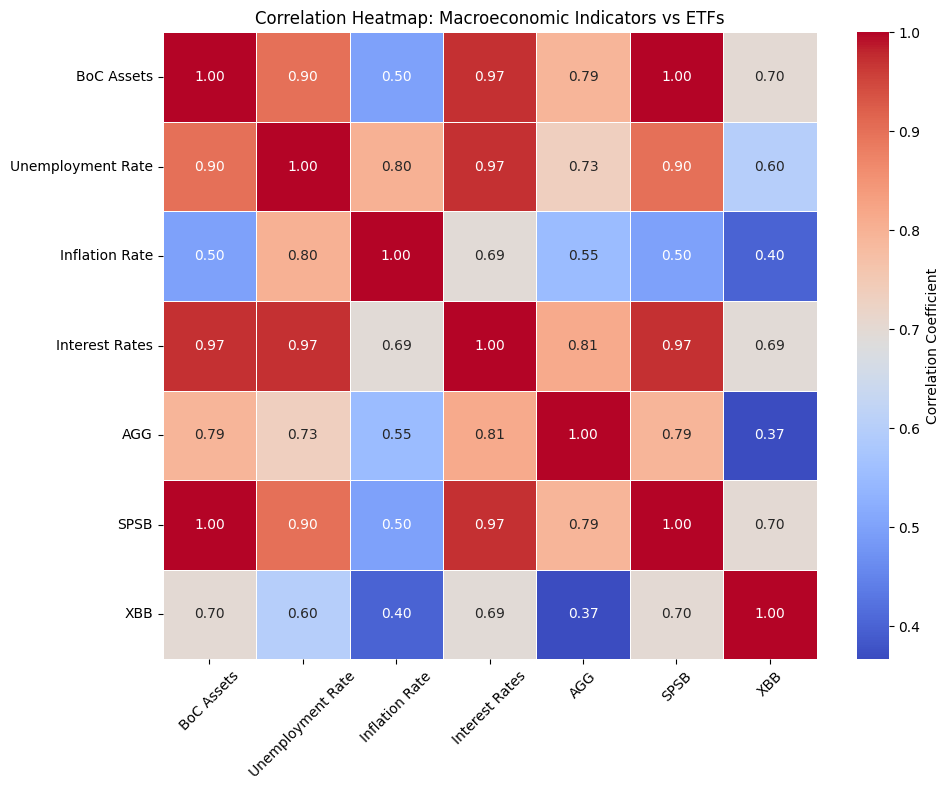

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data (replace with actual data)
data = {
    "BoC Assets": [1.2, 1.3, 1.4, 1.6, 1.5],
    "Unemployment Rate": [5.0, 5.1, 5.3, 5.4, 5.2],
    "Inflation Rate": [2.1, 2.3, 2.5, 2.4, 2.2],
    "Interest Rates": [1.5, 1.6, 1.7, 1.8, 1.7],
    "AGG": [100.5, 101.0, 100.8, 101.2, 100.9],
    "SPSB": [50.1, 50.2, 50.3, 50.5, 50.4],
    "XBB": [28.0, 28.1, 28.3, 28.2, 28.4],
}

# Create a DataFrame
df = pd.DataFrame(data)

# Calculate correlations
correlation_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'Correlation Coefficient'}
)

plt.title("Correlation Heatmap: Macroeconomic Indicators vs ETFs")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


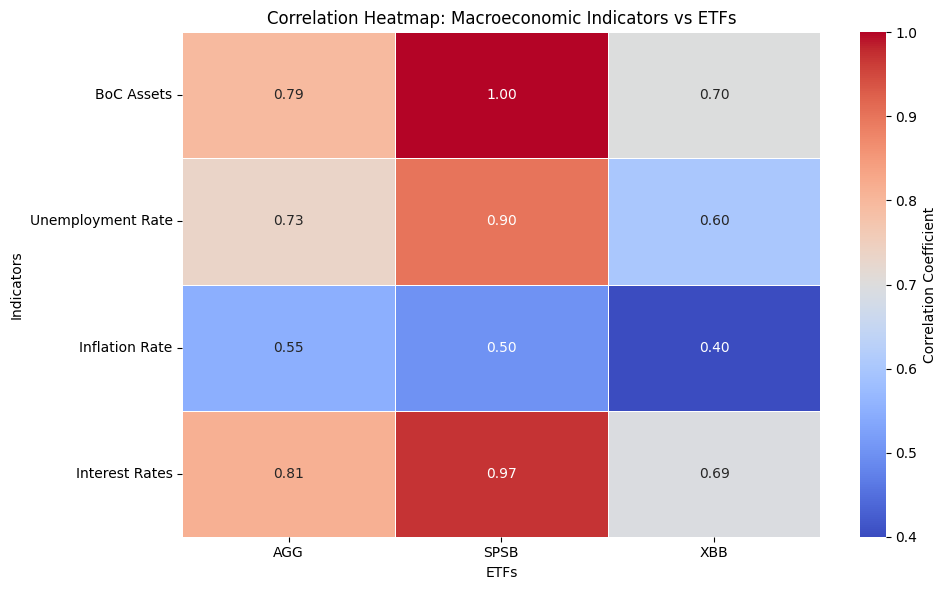

In [3]:
# Split ETFs and indicators into separate axes
etfs = df[["AGG", "SPSB", "XBB"]]
indicators = df[["BoC Assets", "Unemployment Rate", "Inflation Rate", "Interest Rates"]]

# Calculate pairwise correlations between each indicator and each ETF
correlation_df = pd.DataFrame(
    {etf: [indicators[col].corr(etfs[etf]) for col in indicators.columns] for etf in etfs.columns},
    index=indicators.columns,
)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    correlation_df,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'Correlation Coefficient'}
)

plt.title("Correlation Heatmap: Macroeconomic Indicators vs ETFs")
plt.xlabel("ETFs")
plt.ylabel("Indicators")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
import yfinance as yf
from fredapi import Fred
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
from dotenv import load_dotenv
import os

# Load API keys from .env file
load_dotenv()

# Set API Key for FRED
fred = Fred(api_key=os.getenv("FRED_API_KEY"))

# Define date range (last 30 days)
end_date = datetime.today()
start_date = end_date - timedelta(days=365)

# Fetch ETF prices from Yahoo Finance
etf_symbols = ["AGG", "SPSB", "XBB.TO"]  # Example symbols
etf_data_list = []  # To store individual ETF DataFrames

for symbol in etf_symbols:
    try:
        # Download historical data
        data = yf.download(symbol, start=start_date, end=end_date)
        if not data.empty:
            # Add a column for this ETF's "Close" prices
            data = data[["Close"]].rename(columns={"Close": symbol})
            etf_data_list.append(data)
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")

# Combine all ETFs into a single DataFrame
if etf_data_list:
    etf_prices = pd.concat(etf_data_list, axis=1)  # Align on index (dates)
else:
    raise ValueError("No ETF data was fetched successfully.")

# Ensure the index is date-aligned and properly formatted
etf_prices.index = pd.to_datetime(etf_prices.index)

# Fetch macroeconomic indicators from FRED
indicators = {
    "BoC_Assets": "RRPONTSYD",  # Replace with actual FRED code for Bank of Canada assets
    "Unemployment_Rate": "UNRATE",  # U.S. Unemployment Rate
    "Inflation_Rate": "FPCPITOTLZGUSA",  # Inflation Rate (CPI)
    "Interest_Rates": "FEDFUNDS"  # Federal Funds Rate
}
indicator_data = {}

for name, code in indicators.items():
    try:
        series = fred.get_series(code, start_date, end_date)
        if not series.empty:
            indicator_data[name] = series
    except Exception as e:
        print(f"Error fetching indicator {name}: {e}")

# Convert macroeconomic indicators into a DataFrame
if indicator_data:
    indicator_df = pd.DataFrame(indicator_data)
else:
    raise ValueError("No indicator data was fetched successfully.")

print(indicator_df.head(365))

# Align both datasets on dates
etf_prices.index = etf_prices.index.date
indicator_df.index = indicator_df.index.date
combined_df = etf_prices.join(indicator_df, how="outer").dropna()

# Calculate correlations between ETFs and indicators
correlation_df = pd.DataFrame(
    {etf: [indicator_df[ind].corr(etf_prices[etf]) for ind in indicator_df.columns] for etf in etf_prices.columns},
    index=indicator_df.columns,
)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    correlation_df,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'Correlation Coefficient'}
)

plt.title("Correlation Heatmap: Indicators vs ETFs")
plt.xlabel("ETFs")
plt.ylabel("Indicators")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Optional: Display combined data
print(combined_df.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


            BoC_Assets  Unemployment_Rate  Inflation_Rate  Interest_Rates
2023-01-01         NaN                NaN        4.116338             NaN
2023-11-01         NaN                3.7             NaN            5.33
2023-11-16     912.010                NaN             NaN             NaN
2023-11-17     935.803                NaN             NaN             NaN
2023-11-20     953.088                NaN             NaN             NaN
...                ...                ...             ...             ...
2024-11-08     163.621                NaN             NaN             NaN
2024-11-11         NaN                NaN             NaN             NaN
2024-11-12     178.814                NaN             NaN             NaN
2024-11-13     238.106                NaN             NaN             NaN
2024-11-14     214.509                NaN             NaN             NaN

[265 rows x 4 columns]


MergeError: Not allowed to merge between different levels. (2 levels on the left, 1 on the right)